In [ ]:
!pip install yfinance


     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 6.4 MB 37.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import yfinance as yf
import os
import json
import pandas as pd

In [ ]:
DATA_PATH = "bkng_data.json"

In [ ]:
if os.path.exists(DATA_PATH):
    
    with open(DATA_PATH) as f:
        bkng_hist = pd.read_json(DATA_PATH)
else:
    bkng = yf.Ticker("BKNG")
    bkng_hist = bkng.history(period="max")

    
    bkng_hist.to_json(DATA_PATH)

In [ ]:
# Display BOOKING stock price history so we can look at the structure of the data
bkng_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1999-03-31,451.50,517.500,438.0,497.25,1322933,0,0.0
1999-04-01,550.50,552.000,475.5,483.00,483233,0,0.0
1999-04-05,501.00,504.000,435.0,450.75,324917,0,0.0
1999-04-06,452.25,484.125,420.0,474.00,353900,0,0.0
1999-04-07,480.75,487.500,442.5,447.00,156617,0,0.0


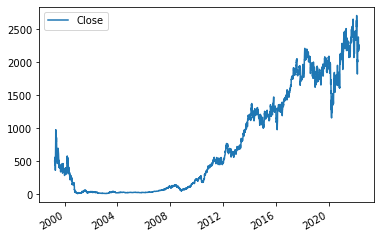

In [ ]:
bkng_hist.plot.line(y="Close", use_index=True)

In [ ]:
# Ensure we know the actual closing price
data = bkng_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = bkng_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [ ]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
bkng_prev = bkng_hist.copy()
bkng_prev = bkng_prev.shift(1)

In [ ]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(bkng_prev[predictors]).iloc[1:]

In [ ]:
data.head(5)

,Actual_Close,Target,Close,Volume,Open,High,Low
1999-04-01,483.00,0.0,497.25,1322933.0,451.50,517.500,438.0
1999-04-05,450.75,0.0,483.00,483233.0,550.50,552.000,475.5
1999-04-06,474.00,1.0,450.75,324917.0,501.00,504.000,435.0
1999-04-07,447.00,0.0,474.00,353900.0,452.25,484.125,420.0
1999-04-08,435.00,0.0,447.00,156617.0,480.75,487.500,442.5


In [ ]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
bkng_prev = bkng_hist.copy()
bkng_prev = bkng_prev.shift(1)


In [ ]:
bkng_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1999-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-04-01,451.50,517.500,438.0,497.25,1322933.0,0.0,0.0
1999-04-05,550.50,552.000,475.5,483.00,483233.0,0.0,0.0
1999-04-06,501.00,504.000,435.0,450.75,324917.0,0.0,0.0
1999-04-07,452.25,484.125,420.0,474.00,353900.0,0.0,0.0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [ ]:
from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5357142857142857

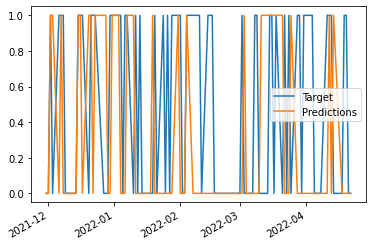

In [ ]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

In [ ]:
i = 600
step = 200

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])

In [ ]:
preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds<=.6] = 0

In [ ]:
preds.head()

2001-08-16    0.0
2001-08-17    0.0
2001-08-20    0.0
2001-08-21    0.0
2001-08-22    0.0
dtype: float64

In [ ]:
predictions = []
# Loop over the dataset in increments
for i in range(600, data.shape[0], step):
    # Split into train and test sets
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    # Fit the random forest model
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict_proba(test[predictors])[:,1]
    preds = pd.Series(preds, index=test.index)
    preds[preds > .6] = 1
    preds[preds<=.6] = 0

    # Combine predictions and test values
    combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

    predictions.append(combined)

In [ ]:
predictions[0].head()

,Target,Predictions
2001-08-16,0.0,0.0
2001-08-17,0.0,0.0
2001-08-20,1.0,0.0
2001-08-21,0.0,0.0
2001-08-22,0.0,0.0


In [ ]:
def backtest(data, model, predictors, start=600, step=200):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

In [ ]:
predictions = backtest(data, model, predictors)


In [ ]:
predictions["Predictions"].value_counts()

0.0    4802
1.0     402
Name: Predictions, dtype: int64

In [ ]:
predictions["Target"].value_counts()


1.0    2661
0.0    2543
Name: Target, dtype: int64

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5149253731343284

In [ ]:
weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]
weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5149253731343284

In [ ]:
# Show how many trades we would make

predictions["Predictions"].value_counts()

0.0    4802
1.0     402
Name: Predictions, dtype: int64

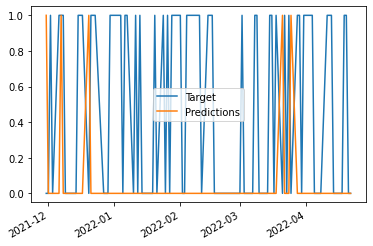

In [ ]:
predictions.iloc[-100:].plot()